product vs pricing Analytics

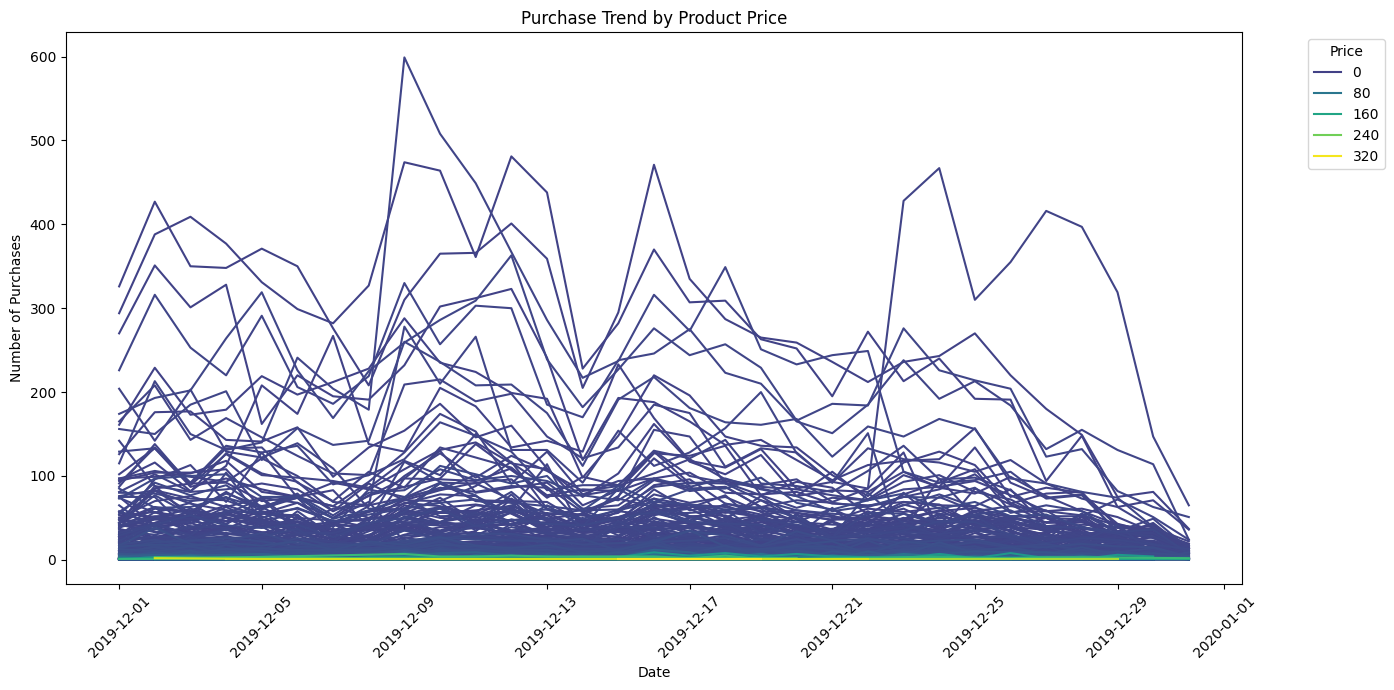

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset (assuming it's saved in parquet format on S3 and loaded as df)
df = pd.read_csv("ecommerce_events.csv")

# Convert event_time to datetime if not already done
df['event_time'] = pd.to_datetime(df['event_time'])

# Extract date from event_time for aggregation
df['date'] = df['event_time'].dt.date

# Group by date and product price to count purchases
price_purchase_trend = df[df['event_type'] == 'purchase'].groupby(['date', 'price']).size().reset_index(name='purchase_count')

# Plotting the trend
plt.figure(figsize=(14, 7))
sns.lineplot(data=price_purchase_trend, x='date', y='purchase_count', hue='price', palette='viridis')
plt.title('Purchase Trend by Product Price')
plt.xlabel('Date')
plt.ylabel('Number of Purchases')
plt.legend(title='Price', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Top 10 Popular Products:
       product_id  purchase_count
10916     5809910            1659
17698     5854897             786
9936      5802432             714
4282      5700037             621
10918     5809912             620
14146     5833330             594
189          5304             549
6484      5751422             548
11958     5815662             521
6452      5751383             435


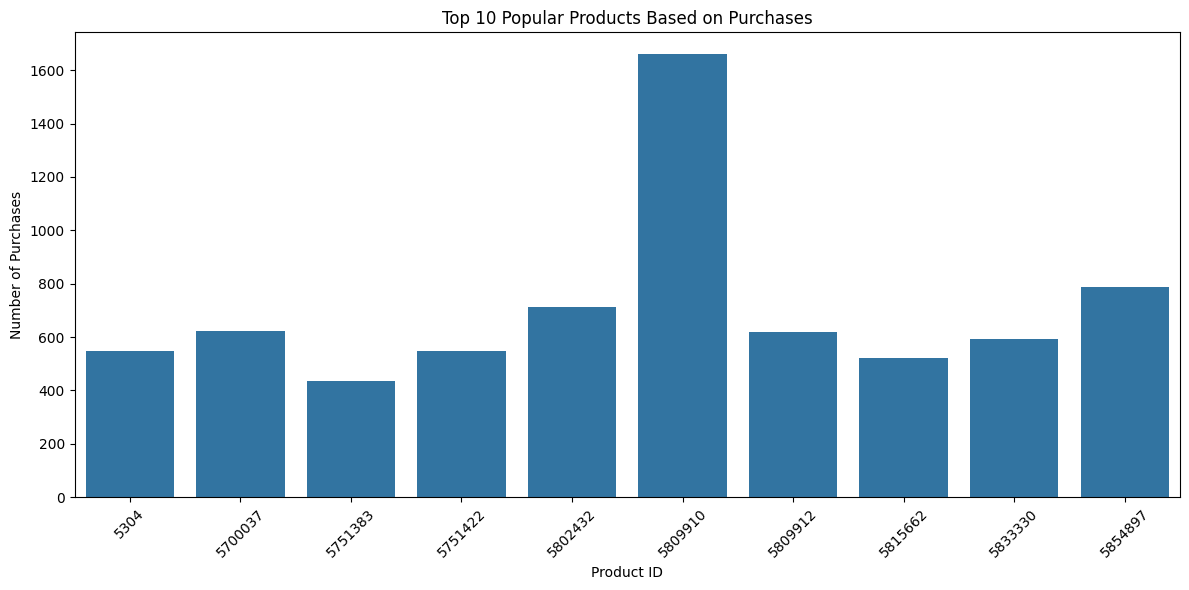

In [3]:
# Calculate product popularity based on purchase counts
product_popularity = df[df['event_type'] == 'purchase'].groupby('product_id').size().reset_index(name='purchase_count')

# Sort products by popularity
product_popularity = product_popularity.sort_values(by='purchase_count', ascending=False)

# Get top 10 products
top_products = product_popularity.head(10)

print("Top 10 Popular Products:")
print(top_products)

# Visualize product popularity
plt.figure(figsize=(12, 6))
sns.barplot(data=top_products, x='product_id', y='purchase_count')
plt.title('Top 10 Popular Products Based on Purchases')
plt.xlabel('Product ID')
plt.ylabel('Number of Purchases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [4]:
import statsmodels.api as sm

# Prepare data for regression analysis
# Selecting only purchase events
purchase_data = df[df['event_type'] == 'purchase']

# Group by product_id to get average price and total purchases
price_purchase_summary = purchase_data.groupby('product_id').agg({'price': 'mean', 'product_id': 'count'}).reset_index()
price_purchase_summary.columns = ['product_id', 'average_price', 'purchase_count']

# Fit a regression model
X = price_purchase_summary['average_price']
y = price_purchase_summary['purchase_count']
X = sm.add_constant(X)  # adding a constant for the intercept
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())


ModuleNotFoundError: No module named 'statsmodels'

In [11]:
# Prepare the purchase data
purchase_data = df[df['event_type'] == 'purchase']

# Group by product_id to get average price and total purchases
price_purchase_summary = purchase_data.groupby('product_id').agg({
    'price': 'mean',
    'product_id': 'count'  # This counts the number of purchases
}).rename(columns={'product_id': 'purchase_count'}).reset_index()

# Rename the columns for clarity
price_purchase_summary.columns = ['product_id', 'average_price', 'purchase_count']

# Prepare the product popularity summary
product_popularity = df.groupby('product_id').agg({
    'event_type': pd.Series.value_counts
}).unstack().fillna(0)

# Reset index to flatten the DataFrame
product_popularity = product_popularity.reset_index()

# If the 'product_id' is duplicated, drop it
if 'product_id' in product_popularity.columns:
    product_popularity = product_popularity.loc[:, ~product_popularity.columns.duplicated()]

# Now merge the DataFrames
recommended_products = product_popularity.merge(price_purchase_summary, on='product_id', how='inner')

# Recommend products with high purchase count and low average price
recommended_products = recommended_products[recommended_products['average_price'] < recommended_products['average_price'].mean()]
recommended_products = recommended_products.sort_values(by='purchase_count', ascending=False)

print("Recommended Products Based on Popularity and Price Sensitivity:")
print(recommended_products[['product_id', 'average_price', 'purchase_count']].head(10))


Recommended Products Based on Popularity and Price Sensitivity:
       product_id  average_price  purchase_count
10916     5809910           5.24            1659
17698     5854897           0.32             786
9936      5802432           0.32             714
4282      5700037           0.40             621
10918     5809912           5.24             620
14146     5833330           0.95             594
189          5304           0.32             549
11958     5815662           0.92             521
10917     5809911           5.24             386
15838     5843836           0.38             354
